In [4]:
class linear_regression:
    def __init__(self, eta = 0.9, max_iter = 1e4, min_weight_dist = 1e-8):
        self.eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0], np.sum(2*delta)/y_real.shape[0]
    def _optimize(self, X, Y):
        #оптимизация коэффициентов
        iter_num = 0
        weight_dist = np.inf
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            gr_w, gr_w0=self._mserror_grad(X, Y)
            if iter_num==0:
                #Чтобы eta адаптировалась к порядку градиента, делим на l2 норму градиента в нуле
                eta=self.eta/np.sqrt(np.linalg.norm(gr_w)**2+(gr_w0)**2)
            new_w = self.w - eta * gr_w
            new_w0= self.w0 - eta * gr_w0
            weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
            iter_num += 1
            self.w = new_w
            self.w0 = new_w0
    def fit(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        self._optimize(X, Y)
    def predict(self, X):
        return (X.dot(self.w.T)+self.w0).flatten()
    def test(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        return self._mserror(X, Y)

In [5]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [6]:
def log_loss_and_grad(w, X, target):
    m = X.shape[0]
    y=(2*target-1)
    score=np.dot(X, w.T).flatten()
    
    # Рассчёт log_loss
    loss = np.sum(np.log(1+np.exp(-y*score)))/m 
    
    # Рассчёт градиента
    Z=-y/(m*(1+np.exp(y*score)))
    grad=Z[np.newaxis, :].dot(X)
    return loss, grad


def optimize(w, X, y, n_iterations, eta):
    #     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss_and_grad(w, X, y)
        w = w - eta * grad
        losses.append(loss)
        
    return w, losses

def predict(w, X):
    y_predicted = np.zeros(X.shape[0])  
    score=np.dot(X, w.T).flatten()
    Prob = 1/(1+np.exp(-score))
    
    #     За порог отнесения к тому или иному классу примем вероятность 0.5
    y_predicted[Prob>0.5]=1
    y_predicted[Prob<=0.5]=0
        
    return y_predicted

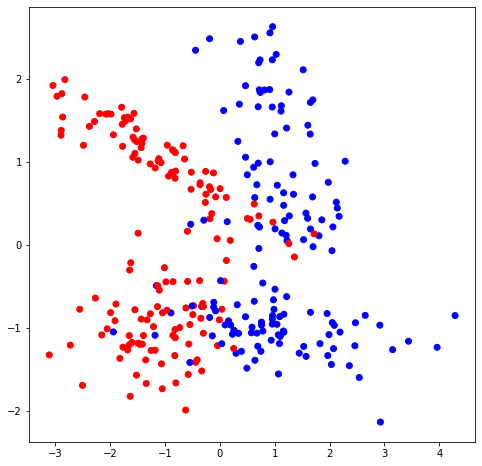

In [86]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=300, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [87]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (210, 2)
Размер массива признаков тестовой выборки (90, 2)
Размер массива ответов для обучающей выборки (210,)
Размер массива ответов для тестовой выборки (90,)


In [88]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    def _log_grad(self, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, self.w.T).flatten()+self.w0
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    def _optimize(self, X, y):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, y)
            self.w = self.w-self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
    def fit(self, X, y):
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        self._optimize(X, y)
    def predict_proba(self, X):  
        '''
        Рассчёт вероятности
        '''
        score=X.dot(self.w.T).flatten()+self.w0
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

In [89]:
mod=logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.11669558 0.00180821]]
Точность на обучающей выборке: 89.524
Точность на тестовой выборке: 88.889


In [90]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [91]:
print("Для порога по вероятности 0.5 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test), y_test)}")
print("Для порога по вероятности 0.75 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, 0.75), y_test)}")

Для порога по вероятности 0.5 на тестовой выборке имеем: {'TP': 41, 'FP': 4, 'FN': 6, 'TN': 39}
Для порога по вероятности 0.75 на тестовой выборке имеем: {'TP': 0, 'FP': 0, 'FN': 47, 'TN': 43}


In [92]:
cofusion_fixed=confusion(mod.predict(X_test), y_test)
sensitivity=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FN'])
specificity=cofusion_fixed['TN']/(cofusion_fixed['TN']+cofusion_fixed['FP'])
balanced_accuracy=(sensitivity+specificity)/2
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность {sensitivity},"+
      f"специфичность {specificity}, сбалансированную точность {balanced_accuracy}")

Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность 0.8723404255319149,специфичность 0.9069767441860465, сбалансированную точность 0.8896585848589806


In [93]:
precision=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FP'])
recall=sensitivity
f1_score=2*precision*recall/(precision+recall)
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: точность {precision},"+
      f"полноту {recall}, f1-скор {f1_score}")

Для порога по вероятности 0.5 на тестовой выборке имеем: точность 0.9111111111111111,полноту 0.8723404255319149, f1-скор 0.891304347826087


In [94]:
probability_list = np.unique(mod.predict_proba(X_test))
print(probability_list)

[0.41658028 0.41729747 0.41892572 0.42537416 0.42913404 0.44283829
 0.44836545 0.45028266 0.45110526 0.45257766 0.45425295 0.45472566
 0.45597688 0.45621656 0.45681612 0.45798496 0.45971349 0.46236127
 0.46640733 0.46724826 0.46770523 0.46799383 0.47008886 0.47079089
 0.47227369 0.47273358 0.47479144 0.4779019  0.48229134 0.48246785
 0.48328135 0.4848455  0.48694628 0.48949    0.49000678 0.49020338
 0.49055479 0.49124891 0.49250239 0.49441402 0.49448993 0.49512459
 0.49528464 0.49598293 0.49977731 0.50010291 0.50036297 0.50364528
 0.50640149 0.50660895 0.50676286 0.5145641  0.51838499 0.51987166
 0.52041929 0.52049226 0.52124068 0.52129263 0.52141342 0.52187566
 0.52195078 0.52218201 0.52651926 0.52699627 0.52717811 0.527897
 0.53002754 0.53041162 0.53068613 0.53277376 0.53284387 0.53319745
 0.5348647  0.53563317 0.53709484 0.54690049 0.55207917 0.55598084
 0.55612281 0.55685704 0.55796425 0.55866331 0.55889522 0.5707411
 0.57242839 0.57585867 0.58316821 0.59800986 0.61249974 0.6216850

In [95]:
def confusion_tn(predicted, actual):
    neg=np.sum(np.logical_and(predicted==0, actual==0))
    return neg

neg_list = []
for i in probability_list:
    neg_list.append(confusion_tn(mod.predict(X_test, i), y_test))

In [96]:
neg_list = np.array(neg_list)

In [97]:
print(neg_list)

[ 1  2  3  4  5  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 36 37 38 39 39 39 39 39 39 40 40
 41 41 41 41 41 41 41 42 42 42 42 42 42 42 42 42 42 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43]


In [98]:
def confusion_fn(predicted, actual):
    pos=np.sum(np.logical_and(predicted==0, actual==1))
    return pos

pos_list = []
for i in probability_list:
    pos_list.append(confusion_fn(mod.predict(X_test, i), y_test))

In [99]:
pos_list = np.array(pos_list)

In [100]:
print(pos_list)

[ 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  3  4  5  6  7  7  8
  8  9 10 11 12 13 14 14 15 16 17 18 19 20 21 22 23 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


In [101]:
#Чувствительность, доля объектов негативного класса, которых при текущем значении предела
#правильно записали в негативный класс
TPR=np.concatenate([[0], neg_list/43])

#Ложно-позитивный уровень, доля объектов положительного класса, которых при текущем значении предела
#ошибочно записали в негативный класс
FPR=np.concatenate([[0], pos_list/47])

In [102]:
TPR

array([0.        , 0.02325581, 0.04651163, 0.06976744, 0.09302326,
       0.11627907, 0.11627907, 0.13953488, 0.1627907 , 0.18604651,
       0.20930233, 0.23255814, 0.25581395, 0.27906977, 0.30232558,
       0.3255814 , 0.34883721, 0.37209302, 0.39534884, 0.41860465,
       0.44186047, 0.46511628, 0.48837209, 0.51162791, 0.53488372,
       0.55813953, 0.58139535, 0.60465116, 0.62790698, 0.65116279,
       0.6744186 , 0.69767442, 0.72093023, 0.74418605, 0.76744186,
       0.79069767, 0.81395349, 0.8372093 , 0.8372093 , 0.86046512,
       0.88372093, 0.90697674, 0.90697674, 0.90697674, 0.90697674,
       0.90697674, 0.90697674, 0.93023256, 0.93023256, 0.95348837,
       0.95348837, 0.95348837, 0.95348837, 0.95348837, 0.95348837,
       0.95348837, 0.97674419, 0.97674419, 0.97674419, 0.97674419,
       0.97674419, 0.97674419, 0.97674419, 0.97674419, 0.97674419,
       0.97674419, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [103]:
FPR

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.04255319, 0.04255319,
       0.04255319, 0.04255319, 0.06382979, 0.08510638, 0.10638298,
       0.12765957, 0.14893617, 0.14893617, 0.17021277, 0.17021277,
       0.19148936, 0.21276596, 0.23404255, 0.25531915, 0.27659574,
       0.29787234, 0.29787234, 0.31914894, 0.34042553, 0.36170213,
       0.38297872, 0.40425532, 0.42553191, 0.44680851, 0.46808511,
       0.4893617 , 0.4893617 , 0.5106383 , 0.53191489, 0.55319149,
       0.57446809, 0.59574468, 0.61702128, 0.63829787, 0.65957

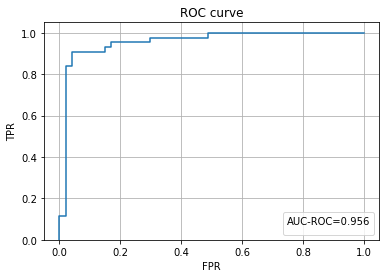

In [104]:
AUC_ROC = np.sum(0.5*(FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1]))

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

In [105]:
precision=neg_list/(neg_list+pos_list)
precision

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.83333333, 0.85714286, 0.875     , 0.88888889, 0.9       ,
       0.90909091, 0.91666667, 0.92307692, 0.92857143, 0.93333333,
       0.9375    , 0.94117647, 0.94444444, 0.94736842, 0.95      ,
       0.95238095, 0.95454545, 0.95652174, 0.95833333, 0.96      ,
       0.96153846, 0.96296296, 0.96428571, 0.96551724, 0.96666667,
       0.96774194, 0.96875   , 0.96969697, 0.97058824, 0.97142857,
       0.97222222, 0.97297297, 0.94736842, 0.94871795, 0.95      ,
       0.95121951, 0.92857143, 0.90697674, 0.88636364, 0.86666667,
       0.84782609, 0.85106383, 0.83333333, 0.83673469, 0.82      ,
       0.80392157, 0.78846154, 0.77358491, 0.75925926, 0.74545455,
       0.75      , 0.73684211, 0.72413793, 0.71186441, 0.7       ,
       0.68852459, 0.67741935, 0.66666667, 0.65625   , 0.64615385,
       0.65151515, 0.64179104, 0.63235294, 0.62318841, 0.61428571,
       0.6056338 , 0.59722222, 0.5890411 , 0.58108108, 0.57333

In [106]:
recall = TPR
recall

array([0.        , 0.02325581, 0.04651163, 0.06976744, 0.09302326,
       0.11627907, 0.11627907, 0.13953488, 0.1627907 , 0.18604651,
       0.20930233, 0.23255814, 0.25581395, 0.27906977, 0.30232558,
       0.3255814 , 0.34883721, 0.37209302, 0.39534884, 0.41860465,
       0.44186047, 0.46511628, 0.48837209, 0.51162791, 0.53488372,
       0.55813953, 0.58139535, 0.60465116, 0.62790698, 0.65116279,
       0.6744186 , 0.69767442, 0.72093023, 0.74418605, 0.76744186,
       0.79069767, 0.81395349, 0.8372093 , 0.8372093 , 0.86046512,
       0.88372093, 0.90697674, 0.90697674, 0.90697674, 0.90697674,
       0.90697674, 0.90697674, 0.93023256, 0.93023256, 0.95348837,
       0.95348837, 0.95348837, 0.95348837, 0.95348837, 0.95348837,
       0.95348837, 0.97674419, 0.97674419, 0.97674419, 0.97674419,
       0.97674419, 0.97674419, 0.97674419, 0.97674419, 0.97674419,
       0.97674419, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

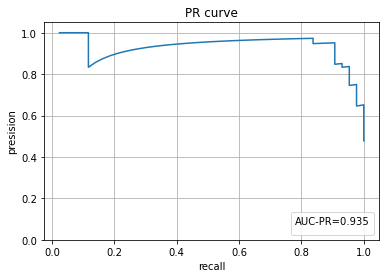

In [107]:
AUC_PR = np.sum(precision*(recall[1:]-recall[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision)